In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import shap

from datetime import datetime,timedelta

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

from statsmodels.tsa.arima.model import ARIMA

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
#only use this for the final lstm model for shap
# import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.experimental.output_all_intermediates(True)
# tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


# Data loading

In [3]:
#load in data sets in pandas dataframe
#smell data
smell_data = pd.read_csv("smell_raw.csv")

# weather data
f26 = pd.read_csv("Feed_26_Lawrenceville_ACHD.csv")
f26pm25 = pd.read_csv("Feed_26_and_Feed_59665_Lawrenceville_ACHD_PM25.csv")
f26pm10 = pd.read_csv("Feed_26_and_Feed_59665_Lawrenceville_ACHD_PM10.csv")
f27 = pd.read_csv("Feed_27_Lawrenceville_2_ACHD.csv")

# Air quality data processing

In [4]:
#Combine the four weather station datasets
#create a column 'date' for each dataframe
f26['Date'] = pd.to_datetime(f26['EpochTime'],unit='s')
f26pm25['Date'] = pd.to_datetime(f26pm25['EpochTime'],unit='s')
f26pm10['Date'] = pd.to_datetime(f26pm10['EpochTime'],unit='s')
f27['Date'] = pd.to_datetime(f27['EpochTime'],unit='s')

#drop the epochtime column
f26 = f26.drop(columns=['EpochTime'])
f26pm25 = f26pm25.drop(columns=['EpochTime'])
f26pm10 = f26pm10.drop(columns=['EpochTime'])
f27 = f27.drop(columns=['EpochTime'])

#create a dataframe with all timestamps between first and last observed value
# Get the start and end timestamps
start_time = datetime(2016, 10, 31, 5, 30)
end_time = datetime(2022, 12, 11, 5, 30)

# Create an empty list to store the timestamps
timestamps = []

# Iterate over the time range
current_time = start_time
while current_time < end_time:
    # Append the current timestamp to the list
    timestamps.append(current_time)
    # Add 1 hour to the current timestamp
    current_time += timedelta(hours=1)

# Create a dataframe from the list of timestamps
time = pd.DataFrame(timestamps, columns=['Date'])

#merge the columns
air= time.merge(f26,on='Date',how='left').merge(f26pm25,on='Date',how='left').merge(f26pm10,on='Date',how='left').merge(f27,on='Date',how='left')


In [5]:
#make a second dataframe in which missing values are removed
airClean = air.copy()

#rename the columns
airClean.rename(columns={'3.feed_26.OZONE_PPM':'OZONE_PPM',
                         '3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3':'PM10_UG_M3',
                         '3.feed_26.SONICWS_MPH':'SONICWS_MPH',
                         '3.feed_26.SONICWD_DEG':'SONICWD_DEG',
                         '3.feed_26.SIGTHETA_DEG':'SIGTHETA_DEG',
                         '3.feed_27.NO_PPB':'NO_PPB',
                         '3.feed_27.NOY_PPB':'NOY_PPB',
                         '3.feed_27.CO_PPB':'CO_PPB',
                         '3.feed_27.SO2_PPB':'SO2_PPB',
                         '3.feed_26.PM25B_UG_M3..3.feed_26.PM25T_UG_M3..3.feed_59665.PM25_640_UG_M3':'PM25_UG_M3'},inplace = True)

#remove missing values
airClean['OZONE_PPM'] = airClean['OZONE_PPM'].interpolate(option='time')
airClean['PM25_UG_M3'] = airClean['PM25_UG_M3'].interpolate(option='time')
airClean['PM10_UG_M3'] = airClean['PM10_UG_M3'].interpolate(option='time')
airClean['SONICWS_MPH'] = airClean['SONICWS_MPH'].interpolate(option='time')
airClean['SONICWD_DEG'] = airClean['SONICWD_DEG'].interpolate(option='time')
airClean['SIGTHETA_DEG'] = airClean['SIGTHETA_DEG'].interpolate(option='time')
airClean['NO_PPB'] = airClean['NO_PPB'].interpolate(option='time')
airClean['NOY_PPB'] = airClean['NOY_PPB'].interpolate(option='time')
airClean['CO_PPB'] = airClean['CO_PPB'].interpolate(option='time')
airClean['SO2_PPB'] = airClean['SO2_PPB'].interpolate(option='time')

#co column has the first value missing so remove it with backwards fill
airClean['CO_PPB'] = airClean['CO_PPB'].bfill()

#change wind direction degrees to a sine/cosine variable
airClean['sin']=np.sin(airClean['SONICWD_DEG']/360*2*math.pi)
airClean['cos']=np.cos(airClean['SONICWD_DEG']/360*2*math.pi)

#drop the degree column
airClean = airClean.drop(columns=['SONICWD_DEG'])

# Smell data processing

In [6]:
#convert epochtime to timestamp
smell_data['Date'] = pd.to_datetime(smell_data['EpochTime'],unit='s')

#sync date from smell reports with airdata 
smell_data['Date'] = smell_data['Date'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,30,0))

#filter zipcodes
zipcodes = [15221,15218,15222,15219,15201,15224,15213,15232,15206,15208,15217,15207,15260,15104]
smell_data = smell_data[smell_data['zipcode'].isin(zipcodes)]

#filter out non-industrial smells
keywords_exclude = ["car","Car","trash","Trash","vehicle","Vehicle","paint",
                    "Paint","garbage","Garbage","sewer","Sewer","sewage","Sewage"]
smell_data = smell_data[smell_data['smell_description'].str.contains("|".join(keywords_exclude))==False]

#use only smell values above 2
smell_data = smell_data[(smell_data["smell_value"]>=3)&(smell_data["smell_value"]<=5)]

#shorten the df to only smell value and date
df_smell = smell_data[['smell_value','Date']]

#add up smell values for same date
agg_functions = {'smell_value': 'sum'}
df_smell = df_smell.groupby(df_smell['Date']).aggregate(agg_functions).reset_index()

# Combine smell data and air quality data

In [7]:
df_final = pd.merge(airClean,df_smell,on='Date',how='left')
df_final['smell_value'] = df_final['smell_value'].fillna(0)
# df_final = df_final.set_index(df_final['Date'])

# 1. Baseline - persistence algorithm

In [ ]:
#define supervised learning problem
PM25_base = pd.concat([df_final['PM25_UG_M3'].shift(1),df_final['PM25_UG_M3']], axis=1)
PM25_base.columns = ['t-1', 't+1']
# print(pm10.head(5))

#create train and test sets
base_X=PM25_base.values
base_train_size = 43568
base_train, base_test = base_X[1:base_train_size], base_X[base_train_size:]
base_train_X, base_train_y = base_train[:,0], base_train[:,1]
base_test_X, base_test_y = base_test[:,0], base_test[:,1]

#forecasting
base_predictions = list()
for x in base_test_X:
    yhat = x
    base_predictions.append(yhat)

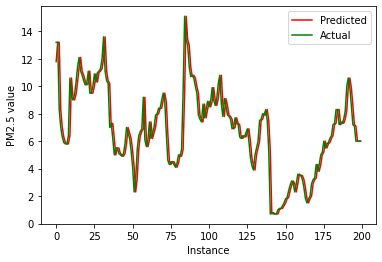

In [ ]:
plt.plot(base_predictions[:200],label='Predicted',color='red')
plt.plot(base_test_y[:200],label='Actual',color='green')
plt.xlabel('Instance')
plt.ylabel('PM2.5 value')
plt.legend()
plt.show()

In [ ]:
#evaluation
baseline_RMSE = np.sqrt(mean_squared_error(base_test_y, base_predictions))
baseline_r2 = r2_score(base_test_y, base_predictions)
baseline_SMAPE = np.mean(2 * np.abs(base_predictions - base_test_y) / (np.abs(base_test_y) + np.abs(base_predictions))) * 100

print('Baseline RMSE: %.5f' % baseline_RMSE)
print('Baseline R2: %.5f' % baseline_r2)
print('Baseline MAPE: %.5f' % baseline_SMAPE)

Baseline RMSE: 1.60864
Baseline R2: 0.89192
Baseline MAPE: 10.72164
Baseline MAE: 0.91646


# 2. ARIMA model

In [8]:
#create dataframe with only pm25
df_arima = df_final['PM25_UG_M3'].to_frame()

#create train test sets
arima_train_size = int(43568)
arima_train = df_arima[:43568].copy()
arima_test = df_arima[arima_train_size:].copy()

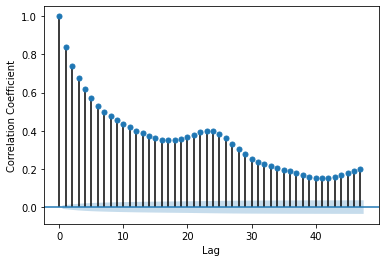

In [9]:
#check for stationarity by looking at acf plot
fig,ax = plt.subplots()
plot_acf(arima_train,ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation Coefficient")
ax.set_title("")
fig.show()

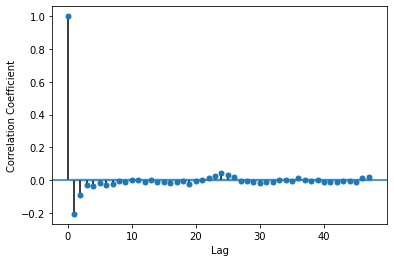

In [10]:
#differentiate and plot again - ACF
arima_train_diff = arima_train.diff().dropna()
fig,ax = plt.subplots()
plot_acf(arima_train_diff,ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation Coefficient")
ax.set_title("")
fig.show()

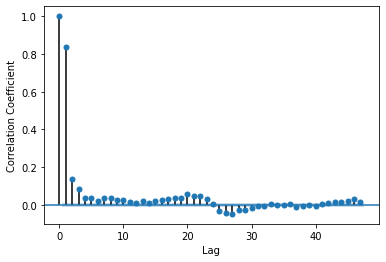

In [11]:
#plot PACF
fig,ax = plt.subplots()
plot_pacf(arima_train,ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation Coefficient")
ax.set_title("")
fig.show()

In [12]:
#fit the model
arima_model = ARIMA(arima_train, order=(2,1,1))
model_fit = arima_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             PM25_UG_M3   No. Observations:                43568
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -116697.101
Date:                Fri, 20 Jan 2023   AIC                         233402.203
Time:                        13:20:19   BIC                         233436.931
Sample:                             0   HQIC                        233413.151
                              - 43568                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6591      0.003    214.217      0.000       0.653       0.665
ar.L2          0.0806      0.003     25.245      0.000       0.074       0.087
ma.L1         -0.9512      0.002   -515.490      0.0

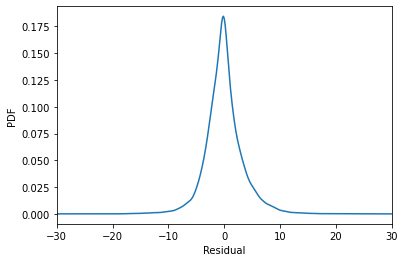

In [25]:
#check residuals
residuals = model_fit.resid[1:]
# fig, ax = plt.subplots(1,2)
# residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde')
plt.xlabel("Residual")
plt.ylabel("PDF")
plt.xlim(-30,30)
plt.show()

In [14]:
#forecast the test set
arima_forecast = model_fit.forecast(len(arima_test))
df_arima['forecast'] = [None]*len(arima_train) + list(arima_forecast)
arima_pred_list = arima_forecast.tolist()

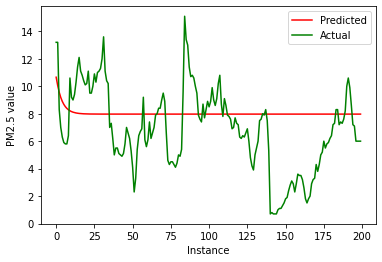

In [15]:
#plot arima predictions
plot_arima_pred = arima_forecast.reset_index()
plot_arima_pred = plot_arima_pred.drop(columns=['index'])

plot_arima_actual = arima_test.reset_index()
plot_arima_actual = plot_arima_actual.drop(columns=['index'])

plt.plot(plot_arima_pred[:200],label='Predicted',color='red')
plt.plot(plot_arima_actual[:200],label='Actual',color='green')
plt.xlabel('Instance')
plt.ylabel('PM2.5 value')
plt.legend()
plt.show()

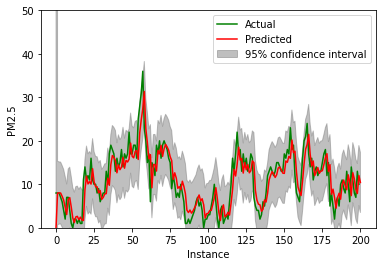

In [16]:
#plot training data
fig, ax = plt.subplots()
arima_train[:200].plot(ax=ax)
plot_predict(model_fit, dynamic=False, start=0, end=200,ax=ax)
lines = ax.get_lines()
lines[0].set_color('green')
lines[0].set_label('Actual')
lines[-1].set_color('red')
lines[-1].set_label('Predicted')
ax.legend()
ax.set_ylim(0, 50) # set y-axis limit from 0 to 50
ax.set_xlabel("Instance")
ax.set_ylabel("PM2.5")
fig.show()

In [17]:
#training predictions
arima_train_predictions = model_fit.predict()
arima_train_pred_list = arima_train_predictions.to_list()
#train evaluation
arima_train_RMSE = np.sqrt(mean_squared_error(arima_train, arima_train_predictions))
arima_train_r2 = r2_score(arima_train, arima_train_predictions)
arima_train_SMAPE = np.mean(2 * np.abs(arima_train_pred_list - arima_train['PM25_UG_M3']) / (np.abs(arima_train['PM25_UG_M3']) + np.abs(arima_train_pred_list))) * 100

print('ARIMA RMSE: %.5f' % arima_train_RMSE)
print('ARIMA R2: %.5f' % arima_train_r2)
print('ARIMA SMAPE: %.5f' % arima_train_SMAPE)

ARIMA RMSE: 3.52426
ARIMA R2: 0.70851
ARIMA SMAPE: 27.59747


In [18]:
#evaluation
arima_RMSE = np.sqrt(mean_squared_error(arima_test, arima_forecast))
arima_r2 = r2_score(arima_test, arima_forecast)
arima_SMAPE = np.mean(2 * np.abs(arima_pred_list - arima_test['PM25_UG_M3']) / (np.abs(arima_test['PM25_UG_M3']) + np.abs(arima_pred_list))) * 100

print('ARIMA RMSE: %.5f' % arima_RMSE)
print('ARIMA R2: %.5f' % arima_r2)
print('ARIMA SMAPE: %.5f' % arima_SMAPE)

ARIMA RMSE: 4.99229
ARIMA R2: -0.04095
ARIMA SMAPE: 41.89583


# 3. Prepare LSTM model

In [ ]:
# split dataset
df_final.index=pd.to_datetime(df_final['Date'])
df_final = df_final.drop(columns=['Date'])

lstm_train_size = 43568
lstm_train = df_final.iloc[0:lstm_train_size,0:]
lstm_test = df_final.iloc[lstm_train_size:,0:]

In [ ]:
#input scaler
sc = StandardScaler()
lstm_train_scaled = sc.fit_transform(lstm_train)
lstm_test_scaled = sc.fit_transform(lstm_test)

#output scaler
sc2 = StandardScaler()
lstm_train_scaled_y = sc2.fit_transform(lstm_train[['PM25_UG_M3']])
lstm_test_scaled_y = sc2.fit_transform(lstm_test[['PM25_UG_M3']])

# 3.1 Train LSTM model

In [ ]:
#create array for previous values for each column
previous = 96
records = lstm_train_scaled.shape[0]
cols = lstm_train_scaled.shape[1]
X_train=[]
y_train=[]
for i in range(previous,records):
    X_train.append(lstm_train_scaled[i-previous:i])
    y_train.append(lstm_train_scaled_y[i][0])
X_train,y_train=np.array(X_train),np.array(y_train) 

print(X_train.shape)
print(y_train.shape)

(43472, 96, 12)
(43472,)


In [ ]:
#reshape array into 3-d array
X_train_shape = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
print(X_train_shape.shape)

(43472, 96, 12)


In [ ]:
#create the model
model = Sequential()
model.add(LSTM(units=8,return_sequences=False,input_shape=(X_train_shape.shape[1],X_train_shape.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 672       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit the model
history = model.fit(X_train_shape,y_train,
                    epochs=64,
                    batch_size=16,
                    validation_split=0.2,
                    shuffle=False)

Train on 34777 samples, validate on 8695 samples
Epoch 1/64
34777/34777 [==============================] - ETA: 0s - loss: 0.4537

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


34777/34777 [==============================] - 130s 4ms/sample - loss: 0.4537 - val_loss: 0.3260
Epoch 2/64
34777/34777 [==============================] - 121s 3ms/sample - loss: 0.3445 - val_loss: 0.2586
Epoch 3/64
34777/34777 [==============================] - 122s 4ms/sample - loss: 0.3266 - val_loss: 0.2402
Epoch 4/64
34777/34777 [==============================] - 121s 3ms/sample - loss: 0.3194 - val_loss: 0.2336
Epoch 5/64
34777/34777 [==============================] - 120s 3ms/sample - loss: 0.3169 - val_loss: 0.2313
Epoch 6/64
34777/34777 [==============================] - 119s 3ms/sample - loss: 0.3118 - val_loss: 0.2305
Epoch 7/64
34777/34777 [==============================] - 119s 3ms/sample - loss: 0.3100 - val_loss: 0.2258
Epoch 8/64
34777/34777 [==============================] - 118s 3ms/sample - loss: 0.3086 - val_loss: 0.2278
Epoch 9/64
34777/34777 [==============================] - 118s 3ms/sample - loss: 0.3058 - val_loss: 0.2247
Epoch 10/64
34777/34777 [==============

In [ ]:
model.save("lstm_final_model.h5")

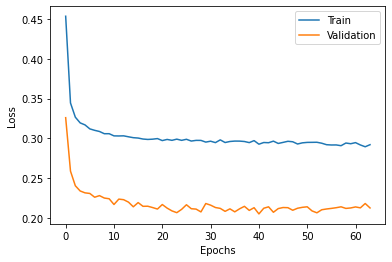

In [ ]:
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

# LSTM model making predictions


In [ ]:
#create array for previous values for each column
records = lstm_test_scaled.shape[0]
cols = lstm_test_scaled.shape[1]
X_test=[]
y_test=[]
for i in range(previous,records):
    X_test.append(lstm_test_scaled[i-previous:i])
    y_test.append(lstm_test_scaled_y[i][0])
X_test,y_test=np.array(X_test),np.array(y_test) 

print(X_test.shape)
print(y_test.shape)

(9904, 96, 12)
(9904,)


In [ ]:
#reshape array into 3-d array
X_test_shape = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))
print(X_test_shape.shape)

(9904, 96, 12)


In [ ]:
lstm_predict = model.predict(X_test_shape)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [ ]:
lstm_predict = sc2.inverse_transform(lstm_predict)
test_y = sc2.inverse_transform([y_test])

In [ ]:
lstm_predictions = pd.DataFrame(lstm_predict, columns=["Predictions"])
lstm_predictions["Actuals"] = test_y[0]

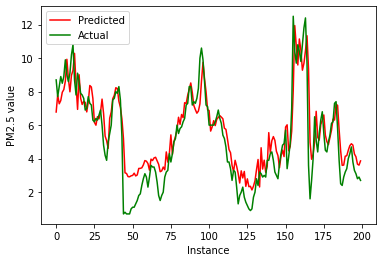

In [ ]:
# plt.figure(figsize=(15,5))
plt.plot(lstm_predictions["Predictions"][:200], label='Predicted',color='red')
plt.plot(lstm_predictions["Actuals"][:200],label='Actual',color='green')
plt.legend()
plt.xlabel('Instance')
plt.ylabel('PM2.5 value')
plt.show()

In [ ]:
lstm_RMSE = np.sqrt(mean_squared_error(test_y[0], lstm_predict[:,0]))
lstm_r2 = r2_score(test_y[0],lstm_predict[:,0])
lstm_SMAPE = np.mean(2 * np.abs(lstm_predict[:,0] - test_y[0]) / (np.abs(test_y[0]) + np.abs(lstm_predict[:,0]))) * 100

print('LSTM RMSE: %.5f' % lstm_RMSE)
print('LSTM R2: %.5f' % lstm_r2)
print('LSTM SMAPE: %.5f' % lstm_SMAPE)

LSTM RMSE: 1.75538
LSTM R2: 0.87210
LSTM SMAPE: 14.22120
LSTM MAE: 1.15857


# Compare results of all models

In [ ]:
#summary of all model evaluations
# baseline_RMSE = np.sqrt(mean_squared_error(base_test_y, base_predictions))
# baseline_r2 = r2_score(base_test_y, base_predictions)

# arima_rmse = np.sqrt(mean_squared_error(arima_test, arima_forecast))
# arima_r2 = r2_score(arima_test, arima_forecast)

# lstm_rmse = np.sqrt(mean_squared_error(test_y[0], lstm_predict[:,0]))
# lstm_r2 = r2_score(test_y[0],lstm_predict[:,0])

print('Baseline RMSE: %.5f' % baseline_RMSE)
print('Baseline R2: %.5f' % baseline_r2)
print('Baseline SMAPE: %.5f' % baseline_SMAPE)

print('ARIMA RMSE: %.5f' % arima_RMSE)
print('ARIMA R2: %.5f' % arima_r2)
print('ARIMA SMAPE: %.5f' % arima_SMAPE)

print('LSTM RMSE: %.5f' % lstm_RMSE)
print('LSTM R2: %.5f' % lstm_r2)
print('LSTM SMAPE: %.5f' % lstm_SMAPE)

Baseline RMSE: 1.60864
Baseline R2: 0.89192
Baseline SMAPE: 10.72164
ARIMA RMSE: 4.99229
ARIMA R2: -0.04095
ARIMA SMAPE: 41.89583
LSTM RMSE: 1.75538
LSTM R2: 0.87210
LSTM SMAPE: 14.22120


# Feature importance

In [ ]:
background = X_train_shape[np.random.choice(X_train_shape.shape[0],500, replace=False)]
random_test = X_test[np.random.choice(X_test.shape[0],200, replace=False)]

In [ ]:
lstm_explain = shap.DeepExplainer(model, background)
shap_values = lstm_explain.shap_values(random_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [ ]:
features = lstm_train.columns

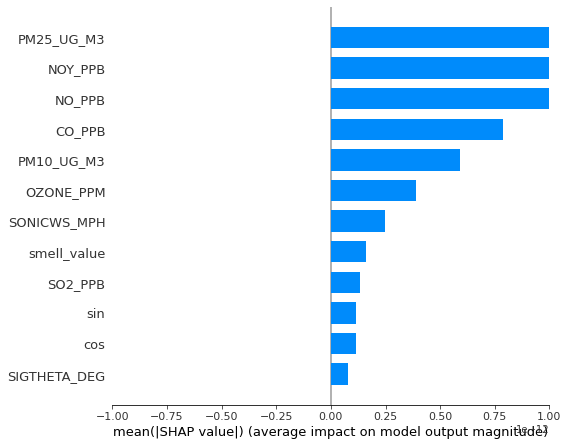

In [ ]:
shap.summary_plot(shap_values[0][:, 0, :], X_train_shape[:,0,:], plot_type = 'bar', feature_names=features)